In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import LineList
from scipy.special import exp1
from physical_constants import RJ, Rsun, MJ, k_B, Gnewton, mamu, gamma
from interpolator import get_interpolated_cross_sections
from ariel_wavelengths import ariel_wavelengths, ariel_bins

### Load the data

In [2]:
opacity_data_path = '../line_lists'

# get all files in the directory which end with .h5
line_list_paths = [f for f in os.listdir(opacity_data_path) if f.endswith('.h5')]

absorbers = [LineList(os.path.join(opacity_data_path, f)) for f in line_list_paths]

# Assert that all absorbers have the same wavelengths
for i in range(len(absorbers)-1):
    assert np.array_equal(absorbers[i].wavelengths, absorbers[i+1].wavelengths), \
        f"Wavelengths of {absorbers[i].name} and {absorbers[i+1].name} do not match."
        
# Since they are the same, get the wavelengths from the first absorber
wavelengths = absorbers[0].wavelengths



# # Assert that all the temperature grids and pressure grids are the same
# for i in range(len(absorbers)-1):
#     assert np.array_equal(absorbers[i].pressures, absorbers[i+1].pressures)
#     assert np.array_equal(absorbers[i].temperatures, absorbers[i+1].temperatures)

# # Since they are the same, get the pressure and temperature grids from the first absorber
# temp_grid = absorbers[0].temperatures
# pressure_grid = absorbers[0].pressures

# print('Temperature grid:', temp_grid)
# print('Pressure grid:', pressure_grid)

Reading in CO2
Reading in CO
Reading in NH3
Reading in CH4
Reading in H2O


### Define the Heng Model:

$$\frac{R_T(\lambda)}{R_S} = \frac{R_0}{R_S} + \frac{H}{R_S} \left[ \gamma_E + \ln\left( \tau_0 \right) + E_1(\tau_0) \right]$$
where
$$\tau_0(\lambda) = \frac{P_0 \, \kappa(\lambda)}{g} \sqrt{2\pi \frac{R_0}{H}}$$
and where
$$\kappa(\lambda) = \kappa_{\text{cl}}(\lambda) + \sum_{a=1}^{N_{\text{abs}}} \frac{X_a m_a}{\bar{m}} \, \chi_a(\lambda, T, P_0)$$


In [3]:
def get_m_bar(concentrations):
    """
    Calculate the mean molecular mass of the atmosphere.
    concentrations: list of absolute concentrations of each absorber

    We include the contribution of H2 and He in the mean molecular mass, 
    which are assumed to have a relative concentration of 0.17 which gives a mean molecular mass of 2.34

    Returns the mean molecular mass in amu.
    """

    # Start with the contribution of H2 and He
    mbar = (1 - np.sum(list(concentrations.values()))) * 2.34

    # Add the contributions to the mass from each absorber
    for absorber in absorbers:
        mbar += concentrations[absorber.molecule_name] * absorber.molecular_mass

    return mbar


def get_kappa(concentrations, temperature, pressure):
    """
    Computes the mass absorption coefficient (kappa) in m²/kg at a given pressure and temperature.

    Parameters:
        concentrations: dict[str, float]
            Absolute concentrations of each absorber, keyed by molecule name.
        temperature: float
            Atmospheric temperature in Kelvin.
        pressure: float
            Atmospheric pressure in bar.

    Returns:
        kappa: np.ndarray
            1D array of opacities [m²/kg] at each wavelength.
    """

    # Compute mean molecular mass
    m_bar = get_m_bar(concentrations)  # amu
    m_bar_kg = m_bar * mamu            # kg

    # Initialize opacity array
    kappa = np.zeros(len(wavelengths))

    # Loop over absorbers
    for absorber in absorbers:
        # Get the name and make sure it exists in the concentrations dict
        name = absorber.molecule_name
        if name not in concentrations:
            raise ValueError(f"Missing concentration for absorber: '{name}'")

        ### We will implement this formula: X_a * m_a * chi_a / m_bar

        concentration = concentrations[name] # This is $X_a$, the absolute concentration of the absorber

        # Get the molecular mass of the absorber and convert it to kg
        molecular_mass_kg = absorber.molecular_mass * mamu # This is $m_a$

        # Get the interpolated cross sections for the absorber at the given pressure and temperature
        chi = get_interpolated_cross_sections(pressure, temperature, absorber) # This is $\Chi_a$ in cm²/molecule
        chi_meters = chi * 1e-4 # in m²/molecule
        chi_SI = chi_meters / molecular_mass_kg # in m²/kg # Allegedly this is the correct way to do it???

        kappa += concentration * molecular_mass_kg * chi_SI / m_bar_kg

    return kappa


def compute_scale_height(T, g, concentrations):
    """
    Compute the scale height of the atmosphere, given:
    - T: temperature in Kelvin
    - g: gravitational acceleration in m/s^2
    - concentrations: relative abundances of the species in the atmosphere (these are used to compute the mean molecular weight)
    
    Retrurns the scale height in meters!
    """
    m_bar = get_m_bar(concentrations)  # mean molecular weight in amu
    m = m_bar * mamu  # convert mean molecular weight to kg
    return (k_B * T) / (m * g)


def get_tau(concentrations, temperature, pressure, planet_radius, g):
    """
    Calculate the optical depth of the atmosphere.
    """
    # kappa = get_kappa(concentrations, temperature, pressure) # in cm²/molecule
    kappa = get_kappa(concentrations, temperature, pressure) # in m²/kg
    H = compute_scale_height(temperature, g, concentrations) # In meters
    pressure_SI = pressure * 1e5  # Convert pressure from atm to Pa
    tau = (pressure_SI * kappa / g) * np.sqrt(2 * np.pi * planet_radius / H)
    return tau   # Which is dimensionless!


def compute_scale_height(T, g, concentrations):
    """
    Compute the scale height of the atmosphere, given:
    - T: temperature in Kelvin
    - g: gravitational acceleration in m/s^2
    - concentrations: relative abundances of the species in the atmosphere (these are used to compute the mean molecular weight)
    
    Retrurns the scale height in meters!
    """
    m_bar = get_m_bar(concentrations)  # mean molecular weight in amu
    m = m_bar * mamu  # convert mean molecular weight to kg
    return (k_B * T) / (m * g)


def get_tau(concentrations, temperature, pressure, planet_radius, g):
    """
    Calculate the optical depth of the atmosphere.
    """
    # kappa = get_kappa(concentrations, temperature, pressure) # in cm²/molecule
    kappa = get_kappa(concentrations, temperature, pressure) # in m²/kg
    H = compute_scale_height(temperature, g, concentrations) # In meters
    pressure_SI = pressure * 1e5  # Convert pressure from atm to Pa
    tau = (pressure_SI * kappa / g) * np.sqrt(2 * np.pi * planet_radius / H)
    return tau   # Which is dimensionless!


def compute_modulation(concentrations, temperature, pressure, planet_radius, star_radius, g):
    """
    Compute the modulation of the light curve due to the atmosphere.
    """
    tau = get_tau(concentrations, temperature, pressure, planet_radius, g)
    print("tau min:", np.min(tau), "tau max:", np.max(tau))
    H = compute_scale_height(temperature, g, concentrations)
    first_term = planet_radius / star_radius
    second_term = (H / star_radius) * (gamma + np.log(tau) + exp1(tau))
    return first_term + second_term

### Run the model

tau min: 0.0006284462853545173 tau max: 4615711470.407677


Text(0.5, 1.0, 'High Resolution Modulation')

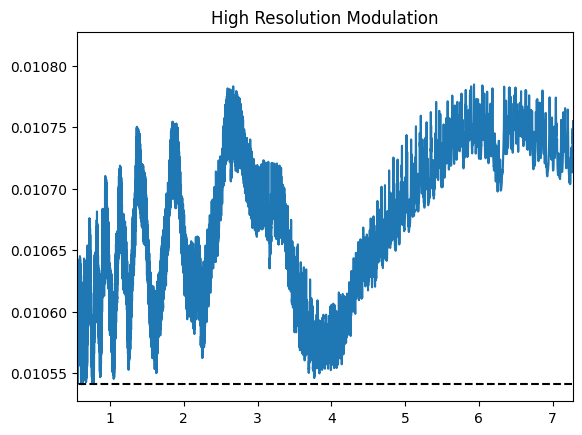

In [4]:
### Parameters for the planet and star:
concentrations = {
    'CO2': 0.0, 
    'CO' : 0.0, 
    'NH3': 0.0, 
    'CH4': 0.0, 
    'H2O': 0.01,
}

temperature = 300  # temperature in Kelvin
pressure = 10 # pressure in bars!
planet_radius = RJ  # radius of the planet in meters
star_radius = Rsun  # radius of the star in meters
planet_mass = MJ    # mass of the planet in kg
# g = g_earth  # gravitational acceleration in m/s^2
g = Gnewton * planet_mass / (planet_radius**2)  # gravitational acceleration at the surface of the planet

### Compute the modulation:
root_modulation = compute_modulation(concentrations, temperature, pressure, planet_radius, star_radius, g)
modulation = root_modulation**2

plt.plot(wavelengths, modulation, label='PyREx')
plt.hlines((planet_radius/star_radius)**2, wavelengths[0], wavelengths[-1], color='black', linestyle='--')
# print(f'STD: {np.std(modulation)}')
plt.xlim(ariel_wavelengths[0], ariel_wavelengths[-1])
# plt.ylim(0.01052, 0.01078)
plt.title('High Resolution Modulation')

#### Bin predicted modulations and compare to TauREx Baseline

Text(0.5, 1.0, 'Binned Modulation Comparison')

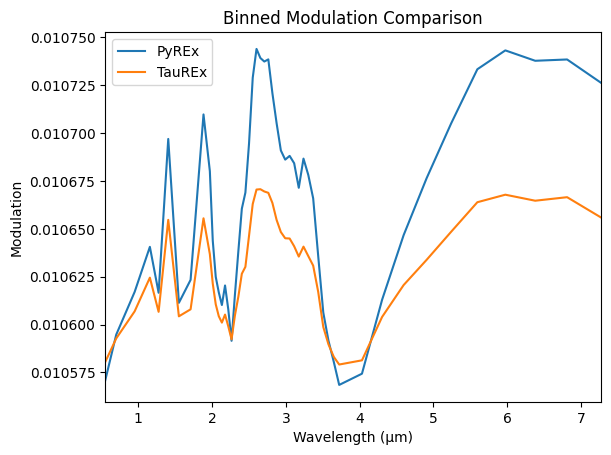

In [5]:
binned_modulations = np.zeros(52)

for i in range(52):
    wavelength_mask = (wavelengths >= ariel_bins[i]) & (wavelengths < ariel_bins[i+1])
    binned_modulations[i] = np.mean(modulation[wavelength_mask])

plt.plot(ariel_wavelengths, binned_modulations, label='PyREx')

# Load the comparison data from TauREx that Emilie provided
comparison_modulations = np.load('data/taurex_comparison/taurex_comparison.npy')
comparison_wavelengths = np.load('data/taurex_comparison/taurex_wavelength.npy')
plt.plot(comparison_wavelengths, comparison_modulations, label='TauREx')

plt.xlim(ariel_wavelengths[0], ariel_wavelengths[-1])
plt.xlabel('Wavelength (µm)')
plt.ylabel('Modulation')
plt.legend()
plt.title('Binned Modulation Comparison')